<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Winter 2022. 
It uses the court data we scraped in October 2021 to model drug crime defelonization policy in VA.

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

In [2]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [3]:
sdc_data = pd.concat([
    pd.read_csv(
        f'../state/VA/VA_data/VA_circuit_data/circuit_data_{i}.csv',
        index_col=0
    ) for i in range(8)
])

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9266/110041657.py:1: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  sdc_data = pd.concat([
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9266/110041657.py:1: DtypeWarning: Columns (18,24) have mixed types.Specify dtype option on import or set low_memory=False.
  sdc_data = pd.concat([


In [4]:
print(sdc_data['Charge Type'].isnull().sum() / len(sdc_data))
sdc_data = sdc_data[sdc_data['Charge Type'].notnull()]

0.0004171301446051168


In [5]:
missing_class_factor = len(sdc_data) / sdc_data.Class.notnull().sum()
sdc_data = sdc_data[sdc_data.Class.notnull()]
missing_class_factor

1.5925273967205706

In [6]:
class_breakdown = sdc_data[sdc_data.crime_type == 'DRUG_POSSESSION'].groupby('Class').count().max(axis=1)
class_breakdown

Class
1     2974
2      691
3       99
4       46
5    51029
6      895
O    12014
U    20396
dtype: int64

In [7]:
sdc_data.loc[sdc_data['Charge Type'] == 'Felony', 'Charge Type'] = 'F'
sdc_data.loc[sdc_data['Charge Type'] == 'Misdemeanor', 'Charge Type'] = 'M'
sdc_data['crime_class'] = sdc_data['Charge Type'] + sdc_data.Class

In [8]:
# We're currently missing a bunch of data that doesn't fall into any category, so we need to scale up counts 
# by the ratio of actual total data to the data we're catching

scale_factor = len(sdc_data) / len(sdc_data[sdc_data.crime_type.notnull()])
sorted_data = sdc_data[sdc_data.crime_type.notnull()]

# Calculate LOS using our percentage served data
sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)

# Drop sentences that will round to 0
sorted_data = sorted_data[sorted_data.LOS > 0.5]

# Calculate time_step column
sorted_data['time_step'] = (sorted_data.year - 2019) * 12 + sorted_data.month
sorted_data = sorted_data[(sorted_data.time_step > -108) & (sorted_data.time_step <= 33)]

# Create outflows table
outflows_data = sorted_data.groupby(['time_step', 'crime_type', 'crime_class']).count()[['Address']].reset_index().rename(
    {'Address': 'total_population', 'crime_class': 'crime'}, axis=1
)
outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.total_population *= scale_factor * missing_class_factor
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_9266/83629553.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sorted_data['LOS'] = sorted_data.apply(lambda x: LOS_BY_CRIME[x.crime_type] * x.total_sentence_months, axis=1)


,time_step,crime_type,crime,total_population,compartment,outflow_to
0,-107,ARSON,F4,2.424769,pretrial,prison
1,-107,ARSON,F5,4.849538,pretrial,prison
2,-107,ARSON,FU,7.274306,pretrial,prison
3,-107,ASSAULT,F2,21.822919,pretrial,prison
4,-107,ASSAULT,F3,72.743063,pretrial,prison


<AxesSubplot:xlabel='time_step'>

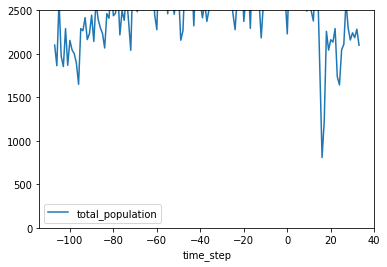

In [9]:
outflows_data.groupby('time_step').sum().plot(ylim=[0,2500])

In [10]:
# Create transitions datta
transitions_data = sorted_data.copy()
transitions_data['compartment_duration'] = transitions_data.LOS.round()
transitions_data = transitions_data.groupby([
    'compartment_duration', 'crime_type', 'crime_class'
]).count()[['Address']].reset_index().rename({'Address': 'total_population', 'crime_class': 'crime'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

# add release transitions as well

# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ARSON': 0.203,
    'ASSAULT': 0.246,
    'BURGLARY': 0.296,
    'CAPITAL_MURDER': 0.073,
    'CONSPIRACY': 0.263,
    'DRUG_OTHER': 0.212,
    'DRUG_POSSESSION': 0.239,
    'DRUG_SALE': 0.193,
    'DWI': 0.184,
    'FIRST_DEGREE_MURDER': 0.073,
    'KIDNAPPING': 0.146,
    'LARCENY': 0.284,
    'MANSLAUGHTER': 0.105,
    'OTHER_MURDER': 0.073,
    'RAPE': 0.226,
    'ROBBERY': 0.206,
    'SECOND_DEGREE_MURDER': 0.073,
    'SEX_OFFENSE': 0.25,        
    'WEAPON': 0.209
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

crime_classes = outflows_data.crime.unique()

for crime in crime_types:
    for crime_class in crime_classes:
        crime_recidivism = recidivism_transitions.copy()
        total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
        crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime]
        crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
        crime_recidivism = crime_recidivism.append({
            'compartment_duration': 36,
            'total_population': 1 - crime_specific_total_recidivism,
            'compartment': 'release',
            'outflow_to': 'release_full',
        }, ignore_index=True)
        crime_recidivism['crime_type'] = crime
        crime_recidivism['crime'] = crime_class

        transitions_data = transitions_data.append(crime_recidivism)

        # adjust outflows so we're not double counting recidivism
        outflows_data.loc[
            (outflows_data.crime_type == crime) & (outflows_data.crime == crime_class), 'total_population'
        ] /= 1 + crime_specific_total_recidivism


crime_class_combination = []
for crime_class in crime_classes:
    crime_class_combination += [crime_class] * len(crime_types)
    

transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types) * len(crime_classes),
    'total_population': [1] * len(crime_types) * len(crime_classes),
    'compartment': ['release_full'] * len(crime_types) * len(crime_classes),
    'outflow_to': ['release_full'] * len(crime_types) * len(crime_classes),
    'crime_type': crime_types * len(crime_classes),
    'crime': crime_class_combination
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime_type,crime,total_population,compartment,outflow_to
0,1.0,ARSON,F1,2.0,prison,release
1,1.0,ARSON,F3,3.0,prison,release
2,1.0,ARSON,F4,13.0,prison,release
3,1.0,ARSON,F5,40.0,prison,release
4,1.0,ARSON,F6,1.0,prison,release


In [11]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [12]:
# REDUCE TO JUST DRUG POSSESSION CUZ THAT'S ALL WE CARE ABOUT

population_breakdown = transitions_data.copy()
population_breakdown['weighted_population'] = \
    population_breakdown.total_population * population_breakdown.compartment_duration
population_breakdown = population_breakdown.groupby('crime_type').sum()
population_breakdown = \
    population_breakdown.weighted_population / population_breakdown.weighted_population.sum()
drug_possession_fraction = population_breakdown.loc['DRUG_POSSESSION']
population_breakdown

crime_type
ARSON                   0.005752
ASSAULT                 0.141264
BURGLARY                0.062296
CAPITAL_MURDER          0.008937
CONSPIRACY              0.012405
DRUG_OTHER              0.056850
DRUG_POSSESSION         0.097422
DRUG_SALE               0.099420
DWI                     0.025575
FIRST_DEGREE_MURDER     0.025556
KIDNAPPING              0.015822
LARCENY                 0.122945
MANSLAUGHTER            0.004106
OTHER_MURDER            0.067900
RAPE                    0.097896
ROBBERY                 0.068418
SECOND_DEGREE_MURDER    0.003556
SEX_OFFENSE             0.010227
WEAPON                  0.073656
Name: weighted_population, dtype: float64

In [13]:
outflows_data = outflows_data[outflows_data.crime_type == 'DRUG_POSSESSION']
transitions_data = transitions_data[
    (transitions_data.crime_type == 'DRUG_POSSESSION') & 
    transitions_data.crime.apply(lambda x: x not in ['InfractionU', 'CivilU', 'M3'])] # add this because there's on drug possession data but that group was added to recidivism data
total_population_data.total_population *= drug_possession_fraction

In [81]:
simulation_tag = "va_drug_defelonization"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/policy_configurations/drug_defelonization_model_inputs.yaml',
)

# Modeling

In [14]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/policy_configurations/drug_defelonization_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 695/695 [00:00<00:00, 1775.35rows/s]
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is depreca

outflows_data returned 695 results


Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:00<00:00, 1140.92rows/s]


transitions_data returned 659 results


Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 121.56rows/s]
crime_type       crime  compartment  outflow_to
DRUG_POSSESSION  F1     pretrial     prison        81.560284
                 F2     pretrial     prison        97.163121
                 F3     pretrial     prison        95.035461
                 F4     pretrial     prison        99.290780
                 M2     pretrial     prison        80.141844
                 M4     pretrial     prison        97.872340
                 MU     pretrial     prison        29.078014
dtype: float64%


total_population_data returned 34 results


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  47.222156047821045


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

simulation_time:  57.77111792564392


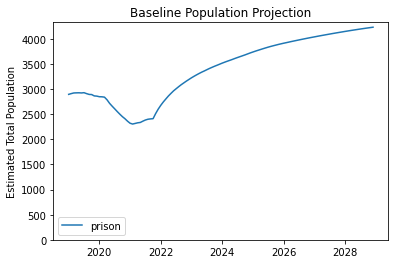

In [15]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'compartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

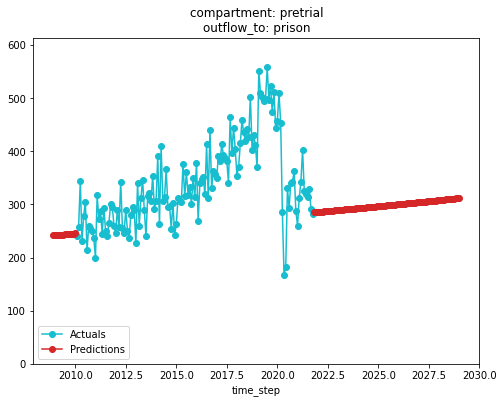

In [16]:
spark_sim.get_arima_output_plots('baseline_projections')

In [17]:
transitions_data.groupby('crime').sum()


,compartment_duration,total_population
crime,,
F1,885.0,38.0
F2,754.0,6.0
F3,837.0,16.0
F4,731.0,3.0
F5,3485.0,17250.0
F6,1504.0,292.0
FU,7324.0,6133.0
M1,902.0,405.0
M2,770.0,36.0


<AxesSubplot:xlabel='compartment_duration'>

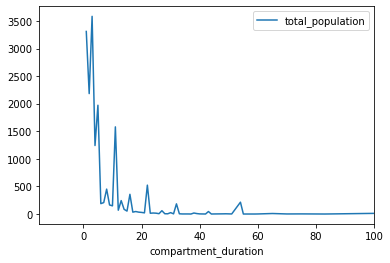

In [18]:
transitions_data[(transitions_data.crime == 'F5') & (transitions_data.compartment == 'prison')].plot(
    y='total_population',x='compartment_duration',xlim=[None,100]
)

<AxesSubplot:xlabel='compartment_duration'>

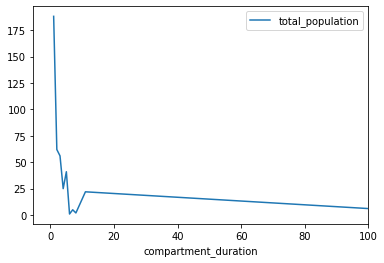

In [91]:
transitions_data[(transitions_data.crime == 'M1') & (transitions_data.compartment == 'prison')].plot(
    y='total_population',x='compartment_duration',xlim=[None, 100]
)

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  48.59211587905884


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)


initialization time:  51.161311864852905


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

simulation_time:  60.27039098739624


../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: Da

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/shell_compartment.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.outflows[self.current_ts] = pd.Series(outflow_dict, dtype=float)
../../../../../recidiviz/calculator/modeling/population_projection/full_compartment.py:141: PerformanceWarning: Dat

simulation_time:  60.0648558139801


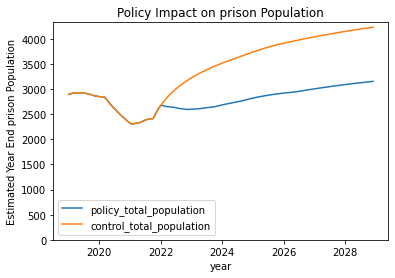

In [19]:
M1_transitions = transitions_data[(transitions_data.crime == 'M1') & (transitions_data.compartment == 'prison')]


# Policy Option Methods
def resentence_drug_possession():
    return partial(TransitionTable.use_alternate_transitions_data, 
                   alternate_historical_transitions=M1_transitions,
                   retroactive=False)

policy_list = [
    SparkPolicy(policy_fn=resentence_drug_possession(),
                spark_compartment='prison',
                sub_population={'crime_type': 'DRUG_POSSESSION', 'crime': 'F5'},
                policy_ts=36,
                apply_retroactive=False)
]

test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [99]:
simulation_tag = 'drug_defelonization_jan_10'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release release_full
 year                                             
 2019.000000              0.0     0.0          0.0
 2019.083333              0.0     0.0          0.0
 2019.166667              0.0     0.0          0.0
 2019.250000              0.0     0.0          0.0
 2019.333333              0.0     0.0          0.0
 2019.416667              0.0     0.0          0.0
 2019.500000              0.0     0.0          0.0
 2019.583333              0.0     0.0          0.0
 2019.666667              0.0     0.0          0.0
 2019.750000              0.0     0.0          0.0
 2019.833333              0.0     0.0          0.0
 2019.916667              0.0     0.0          0.0
 2020.000000              0.0     0.0          0.0
 2020.083333              0.0     0.0          0.0
 2020.166667              0.0     0.0          0.0
 2020.250000              0.0     0.0          0.0
 2020.333333              0.0     0.0          0.0
 2020.416667  

In [12]:
currently_incarcerated = sorted_data[(sorted_data.time_step < 30) & (sorted_data.time_step + sorted_data.compartment_duration > 30)]
len(currently_incarcerated)/len(sorted_data)

0.1119904724316764

In [13]:
len(currently_incarcerated[(currently_incarcerated.crime_class == 'F5') & 
                           (currently_incarcerated.crime_type == 'DRUG_POSSESSION')]) * scale_factor * missing_class_factor

2104.6992878453816

In [14]:
sorted_data[(sorted_data.crime_class == 'F5') 
            & (sorted_data.crime_type == 'DRUG_POSSESSION')].compartment_duration.mean()

7.453935179302107

In [15]:
sorted_data[(sorted_data.crime_class == 'M1') 
            & (sorted_data.crime_type == 'DRUG_POSSESSION')].compartment_duration.mean()

3.228199462932119